# Temperatura diária - Séries temporais

O objetivo desse projeto é construir um modelo preditivo de série temporal usando métodos clássicos de forecasting. Para isso, usa-se uma base de dados de temperaturas diárias entre 1981 e 1990.

O relatório é dividido em quatro etapas:
1. Tratamento da base de dados
2. Modelagem
3. Previsão e avaliação dos modelos
4. Conclusão

# 1. Tratamento da base de dados

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv('temperatures.csv', sep=',')
df.shape

(3650, 2)

In [29]:
df.index = df['Date']
df = df.drop(['Date'], axis=1)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [30]:
sns.set(rc={'figure.figsize':(15, 6)})

<AxesSubplot:xlabel='Date'>

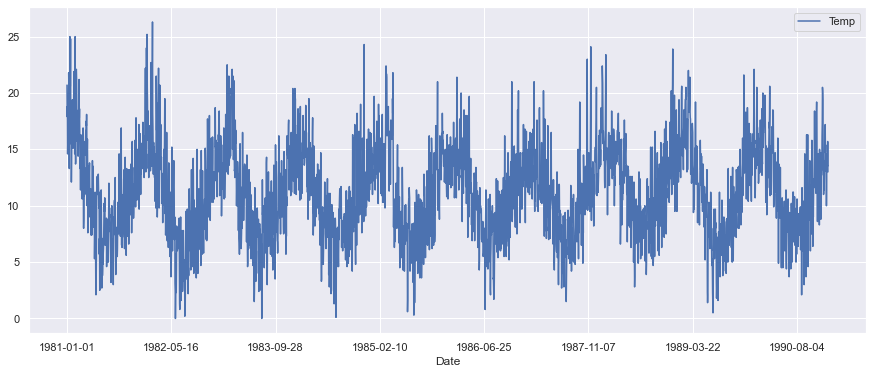

In [31]:
df.plot()

In [32]:
df['Seasonal Difference'] = df['Temp'].diff(periods=12).fillna(0)
df.head(15)

,Temp,Seasonal Difference
Date,,
1981-01-01,20.7,0.0
1981-01-02,17.9,0.0
1981-01-03,18.8,0.0
1981-01-04,14.6,0.0
1981-01-05,15.8,0.0
1981-01-06,15.8,0.0
1981-01-07,15.8,0.0
1981-01-08,17.4,0.0
1981-01-09,21.8,0.0


In [33]:
ad_fuller_result = adfuller(df['Seasonal Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.947173767439947
p-value: 2.5711890273624246e-17


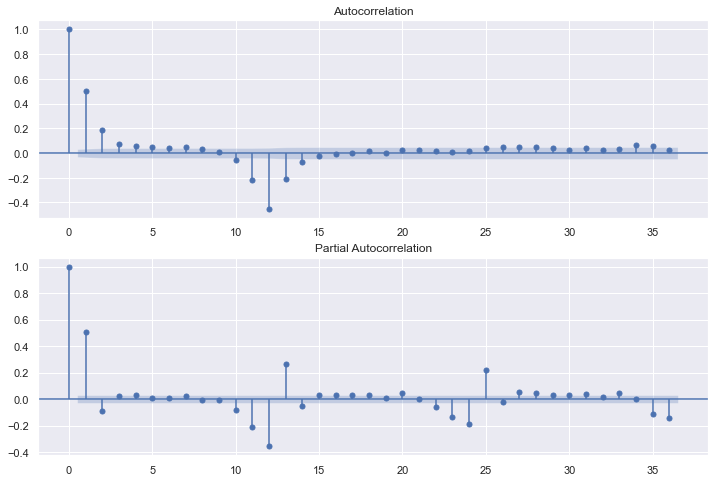

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal Difference'].values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal Difference'], ax=ax2)

In [35]:
df = df.drop(['Temp'], axis=1)

# 2. Modelagem

Para criar o modelo SARIMA, selecionei os seguintes critérios:

O ACF mostra um lag-1 positivo e a autocorrelação cai gradualmente nos lags posteriores e o PCAF cai bruscamente após o lag-2.  Por isso, o modelo se adequaria melhor a uma autoregressão. 
Como o ACF mostra que os 3 primeiros lags são significativos, selecionei um modelo autoregressivo com p=3. Perto do lag-12, há 3 lags significativos, o que mostra que P=3 seria adequado.
Como geralmente modelos autoregressivos não possuem componente de média móvel, q=0 e Q=0.
A série sofreu apenas uma diferenciação, a diferenciação sazonal. Por isso, d=0 e D=1.
Por fim, a sazonalidade do modelo é mensal, levando a m=12.

Portanto, tem-se:
ARIMA(p, d, q)(P, D, Q)m -> ARIMA(3, 0, 0)(3, 1, 0)12

Como o PACF mostra dois lags significativos, também rodei o modelo ARIMA(2, 0, 0)(3, 1, 0)12 para comparar a acurácia.

A série foi dividida em uma base de treino e uma de teste para rodar o modelo e realizar as previsões.

Apesar os índices AIC serem similares entre si, o modelo ARIMA(3, 0, 0)(3, 1, 0)12 tem um AIC, ou seja, provavelmente é um modelo com melhor acurácia. No próximo tópico, os dois modelos são avaliados comparativamente.

In [36]:
train, test = train_test_split(df, train_size=0.75, shuffle=False)
print("train: ", train.shape)
print("test: ", test.shape)

train:  (2737, 1)
test:  (913, 1)


# 2.1 Modelo ARIMA(3, 0, 0)(3, 1, 0)12

In [37]:
mod = SARIMAX(train, order=(3, 0, 0), seasonal_order=(3, 1, 0, 12))
res = mod.fit()
print(res.summary())

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                Seasonal Difference   No. Observations:                 2737
Model:             SARIMAX(3, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -7271.393
Date:                            Tue, 26 Oct 2021   AIC                          14556.785
Time:                                    19:43:41   BIC                          14598.157
Sample:                                         0   HQIC                         14571.739
                                           - 2737                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5796      0.018     32.306      0.000       0.544       0.615
ar.L2         -0.1345      0.022   

# 2.2 Modelo ARIMA(2, 0, 0)(3, 1, 0)12

In [38]:
mod2 = SARIMAX(train, order=(2, 0, 0), seasonal_order=(3, 1, 0, 12))
res2 = mod2.fit()
print(res2.summary())

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                Seasonal Difference   No. Observations:                 2737
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -7273.453
Date:                            Tue, 26 Oct 2021   AIC                          14558.907
Time:                                    19:43:45   BIC                          14594.368
Sample:                                         0   HQIC                         14571.724
                                           - 2737                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5752      0.018     32.178      0.000       0.540       0.610
ar.L2         -0.1120      0.019   

# 3. Previsão e avaliação do modelo

Os dois modelos avaliados possuem comportamentos e índices similares. Os resíduos são padronizados e os valores previstos são bem ajustados à reta da série temporal. Além disso, o histograma do modelo possui uma curva normal e só apresenta uma autocorrelação significativa, o que são indicadores positivos.

Os modelos variam um pouco com relação ao AIC e aos índices de erro das previsões, que possibilitam selecionar o modelo ARIMA(3, 0, 0)(3, 1, 0)12 como o melhor ajustado.

# 3.1 Modelo ARIMA(3, 0, 0)(3, 1, 0)12

<Figure size 1080x864 with 0 Axes>

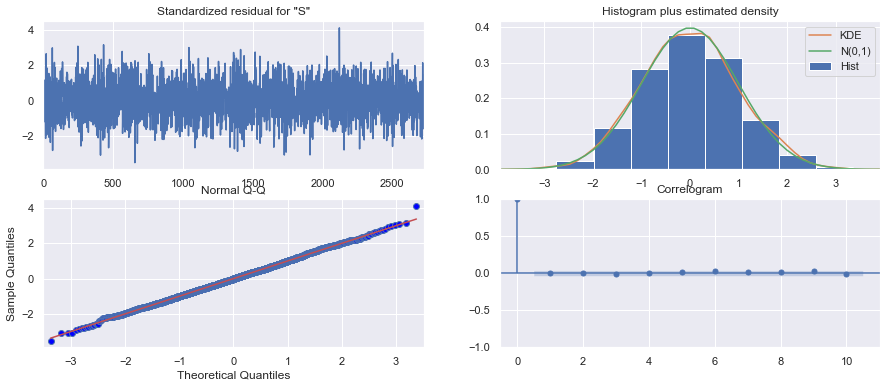

<Figure size 1080x864 with 0 Axes>

In [39]:
res.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [40]:
forecast = res.forecast(913)
forecast

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


2737   -0.059073
2738   -1.174779
2739   -1.970038
2740   -3.285914
2741   -5.041360
          ...   
3645   -0.325236
3646   -1.812697
3647    0.126581
3648   -0.348817
3649   -1.783014
Name: predicted_mean, Length: 913, dtype: float64

In [41]:
rmse = sqrt(mean_squared_error(test, forecast))
rmse

3.863189005823716

In [42]:
mae = mean_absolute_error(test, forecast)
mae

3.077142521841964

In [43]:
# por que o mape está dando esse número doido?
mape = mean_absolute_percentage_error(test, forecast)
mape

46319088516723.54

# 3.2 Modelo ARIMA(2, 0, 0)(3, 1, 0)12

<Figure size 1080x864 with 0 Axes>

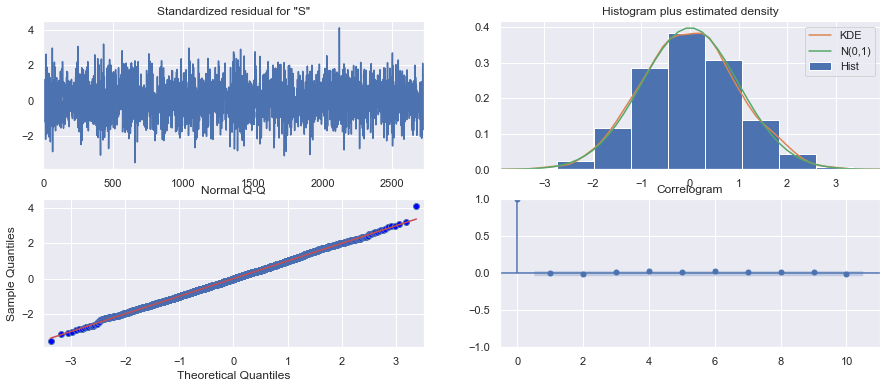

<Figure size 1080x864 with 0 Axes>

In [44]:
res2.plot_diagnostics()
plt.figure(figsize=(15, 12))

In [45]:
forecast = res2.forecast(913)
forecast

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


2737   -0.069692
2738   -1.337018
2739   -2.176975
2740   -3.430127
2741   -5.107817
          ...   
3645   -0.325934
3646   -1.812982
3647    0.127185
3648   -0.349154
3649   -1.785042
Name: predicted_mean, Length: 913, dtype: float64

In [46]:
rmse = sqrt(mean_squared_error(test, forecast))
rmse

3.8695974209321067

In [47]:
mae = mean_absolute_error(test, forecast)
mae

3.082950154591198

In [48]:
# por que o mape está dando esse número doido 2?
mape = mean_absolute_percentage_error(test, forecast)
mape

46721831907129.98

# 4. Conclusão

Nesse projeto, foi criado um modelo de previsão de série temporal relacionada a temperaturas médias.

O modelo com melhor desempenho foi um modelo ARIMA sazonal com os seguintes parametros: ARIMA(3, 0, 0)(3, 1, 0)12.

O modelo apresentou os menores índices de erro de previsão e o menor índice AIC, demonstrando maior acurácia. Os dois modelos rodados possuem níveis similares, mas podem ser distinguidos com relação a esses índices.

Para realizar o modelo, a série sofreu uma diferenciação sazonal e foi dividida em uma série de treino e uma de teste. Além disso, foram criadas previsões bem ajustadas para o modelo.